# ML Workflow with Million Song Dataset 

### 0. Starting Spark Session / Install Libraries

In [1]:
from pyspark.sql import *
import matplotlib.pyplot as plt
import numpy as np

sc = spark.sparkContext
print(f'num executors: {sc.getConf().get("spark.executor.instances")}')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1680138161878_0004,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

num executors: 3

### 1. Data Loading and Preparation from S3

In [3]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

schema = StructType([StructField('song_hotttnesss', DoubleType(), True),
                       StructField('artist_familiarity', DoubleType(), True),
                       StructField('artist_hotttnesss', DoubleType(), True),
                       StructField('artist_id', StringType(), True),
                       StructField('artist_latitude', DoubleType(), True),
                       StructField('artist_location', StringType(), True),
                       StructField('artist_longitude', DoubleType(), True),
                       StructField('artist_name', StringType(), True),
                       StructField('title', StringType(), True),
                       StructField('danceability', DoubleType(), True),
                       StructField('duration', DoubleType(), True),
                       StructField('end_of_fade_in', DoubleType(), True),
                       StructField('energy', DoubleType(), True),
                       StructField('key', DoubleType(), True),
                       StructField('key_confidence', DoubleType(), True),
                       StructField('loudness', DoubleType(), True),
                       StructField('mode', DoubleType(), True),
                       StructField('mode_confidence', DoubleType(), True),
                       StructField('start_of_fade_out', DoubleType(), True),
                       StructField('tempo', DoubleType(), True),
                       StructField('time_signature', DoubleType(), True),
                       StructField('time_signature_confidence', DoubleType(), True),
                       StructField('artist_terms', StringType(), True),
                       StructField('artist_terms_freq', StringType(), True),
                       StructField('artist_terms_weight', StringType(), True),
                       StructField('year', DoubleType(), True)]
                   )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
load_subset = False
s3_bucket_name = 'hw4bucket-yuanche2'

if load_subset:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/A_1.csv")
else:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/*.csv")

print('loaded {} records'.format(df.count()))

fulldfSize = df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loaded 581965 records

In [5]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string

### 2. Exploratory Data Analysis

`danceability` and `energy` are not well-defined, we will remove them. `year` is also bimodally distributed. We will work with songs after 1920.  

In [7]:
plt.clf()

dfSample = df.sample(fraction = 0.01)

songHot = dfSample.rdd.map(lambda row: row.song_hotttnesss).collect()
fam =  dfSample.rdd.map(lambda row: row.artist_familiarity).collect()
artHot =  dfSample.rdd.map(lambda row: row.artist_hotttnesss).collect()
duration =  dfSample.rdd.map(lambda row: row.duration).collect()
tempo =  dfSample.rdd.map(lambda row: row.tempo).collect()
year =  dfSample.rdd.map(lambda row: row.year).collect()


fig, ax = plt.subplots(3, 2)
fig.tight_layout(h_pad=3)

#define subplot titles
ax[0, 0].set_title('Histogram of song_hotttnesss')
ax[0, 1].set_title('Histogram of artist_familiarity')
ax[1, 0].set_title('Histogram of artist_hotttnesss')
ax[1, 1].set_title('Histogram of duration')
ax[2, 0].set_title('Histogram of tempo')
ax[2, 1].set_title('Histogram of year')



plt.subplot(3, 2, 1)
plt.hist(songHot)
plt.xlabel('song_hotttnesss')

plt.subplot(3, 2, 2)
plt.hist(fam)
plt.xlabel('artist_familiarity')

plt.subplot(3, 2, 3)
plt.hist(artHot)
plt.xlabel('artist_hotttnesss')

plt.subplot(3, 2, 4)
plt.hist(duration)
plt.xlabel('duration')


plt.subplot(3, 2, 5)
plt.hist(tempo)
plt.xlabel('tempo')


plt.subplot(3, 2, 6)
plt.hist(year)
plt.xlabel('year')


plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

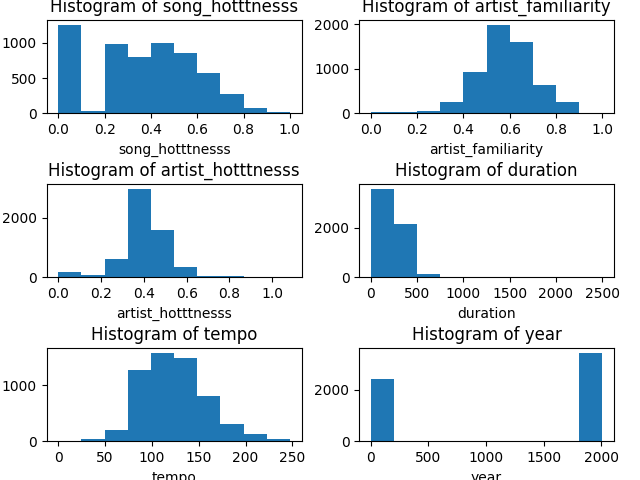

In [8]:
%matplot plt

In [9]:
plt.clf()
dfSample = dfSample.filter(df.year >= 1920)

yearNew =  dfSample.rdd.map(lambda row: row.year).filter(lambda year: year >= 1920).collect()

plt.hist(yearNew)
plt.xlabel('year')
plt.title("Histogram of year (cleaned)")
plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

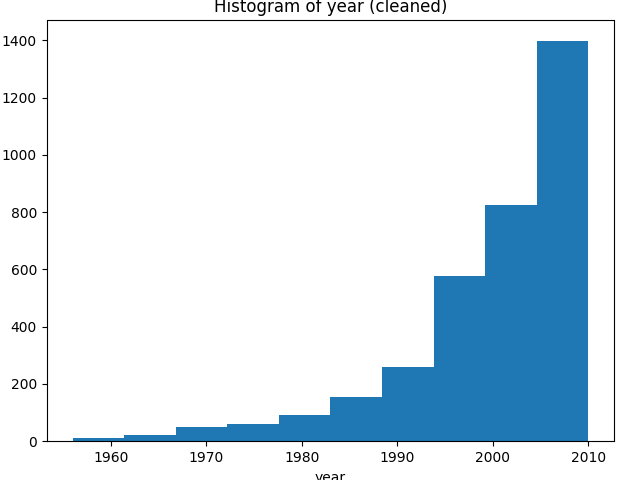

In [10]:
%matplot plt

We will now subsample our dataset to produce some relevant scatterplots. 

In [11]:
songHot = dfSample.rdd.map(lambda row: row.song_hotttnesss).collect()
fam =  dfSample.rdd.map(lambda row: row.artist_familiarity).collect()
artHot =  dfSample.rdd.map(lambda row: row.artist_hotttnesss).collect()
duration =  dfSample.rdd.map(lambda row: row.duration).collect()
tempo =  dfSample.rdd.map(lambda row: row.tempo).collect()
year =  dfSample.rdd.map(lambda row: row.year).collect()
lat =  dfSample.rdd.map(lambda row: row.artist_latitude).collect()
long =  dfSample.rdd.map(lambda row: row.artist_longitude).collect()

plt.clf()

fig, ax = plt.subplots(3, 1, figsize=(7,10))
fig.tight_layout(w_pad = 5,h_pad=3.5)
plt.subplots_adjust(left = 0.1)


#define subplot titles
ax[0].set_title('song_hotttnesss vs. artist_familiarity')
ax[1].set_title('artist_latitude vs. artist_longitude')
ax[2].set_title('song_hotttnesss vs. year')

plt.subplot(3, 1, 1)
plt.scatter(fam, songHot)
plt.ylabel('song_hotttnesss')
plt.xlabel("song_familiarity")

plt.subplot(3, 1, 2)
plt.scatter(long, lat)
plt.xlabel('artist_longitude')
plt.ylabel("artist_latitude")

plt.subplot(3, 1, 3)
plt.scatter(year, artHot)
plt.xlabel('year')
plt.ylabel("artist_hotttnesss")

plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

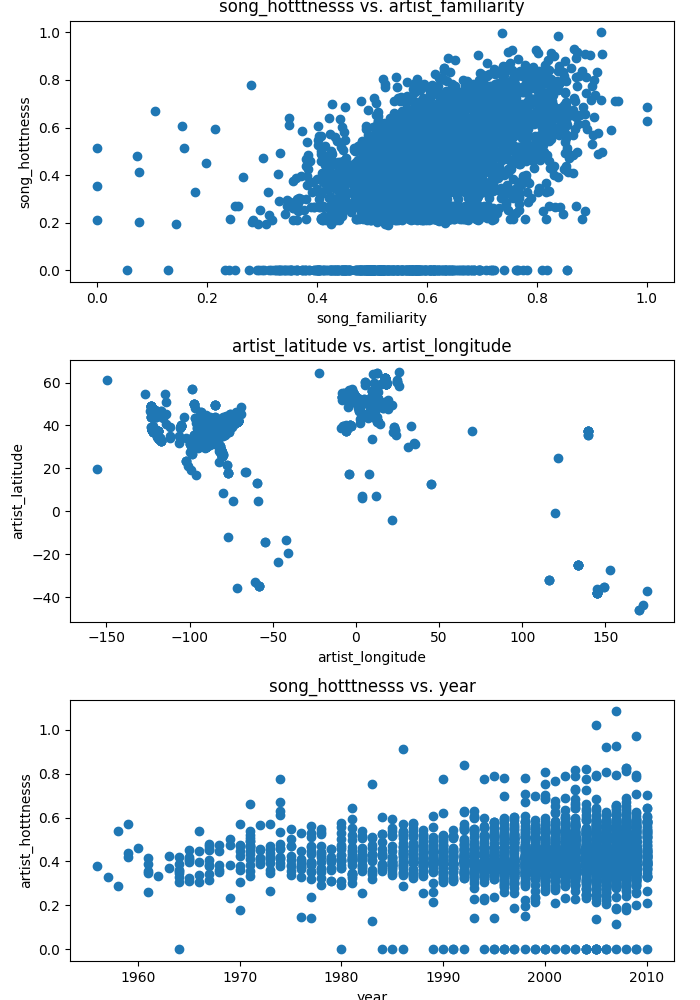

In [12]:
%matplot plt

### 3. Data Cleaning

First drop `energy` and `danceability` features and year below 1920. 



In [13]:
df = df.drop("energy")
df = df.drop("danceability")
df = df.filter(df.year >= 1920)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
print('Remaining records: {}'.format(df.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Remaining records: 346444

We realize some `arrtist_longitude` and `artist_latitiude` values are null. Will remove those with null values. 

In [15]:
from pyspark.sql.functions import isnan, when, count, isnull

columns = [entry[0] for entry in df.dtypes]
df.select([count(when(isnan(c), c)).alias(c) for c in columns]).collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(song_hotttnesss=0, artist_familiarity=1, artist_hotttnesss=0, artist_id=0, artist_latitude=219399, artist_location=0, artist_longitude=219399, artist_name=0, title=1, duration=0, end_of_fade_in=0, key=0, key_confidence=0, loudness=0, mode=0, mode_confidence=0, start_of_fade_out=0, tempo=0, time_signature=0, time_signature_confidence=0, artist_terms=0, artist_terms_freq=0, artist_terms_weight=0, year=0)]

In [16]:
df = df.filter("not (isnan(artist_latitude) or isnan(artist_longitude)) ")
print('Remaining records: {}'.format(df.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Remaining records: 127045

Percentage of surviving datapoints:

In [17]:
df.count()/fulldfSize

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.21830350622460112

### 4. Baseline

We will be treating this problem as a classification problem, i.e. given some features, predict whether a song will be popular. We define a song to be popular if its `song_hotttnesss` value is above average. We will assign labels to the dataset with the above definition of "popularity".

In [18]:
from pyspark.sql.functions import col, expr, when

meanHotness = np.mean(df.rdd.map(lambda row: row.song_hotttnesss).collect())
df = df.withColumn("label", (col("song_hotttnesss") > meanHotness).cast("integer"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Class balance between popular = 1 and popular = 0

In [19]:
above = df.rdd.map(lambda row: row.label).collect().count(1)
below = df.rdd.map(lambda row: row.label).collect().count(0)

print(f'below average count: {below}')
print(f'above average count: {above}')

print(above/(above + below))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

below average count: 55908
above average count: 71137
0.5599354559408084

`year` feature centering

In [20]:
minYear = np.min(df.rdd.map(lambda row: row.year).collect())
df = df.withColumn("year", df.year - minYear)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

concatenate all features using VectorAssembler into a feature vector and scale it. 

In [21]:
# assembling vector

from pyspark.ml.feature import VectorAssembler
vectorizer = VectorAssembler(inputCols = ['artist_familiarity', 
                         'artist_hotttnesss',
                         'artist_latitude', 
                         'artist_longitude', 
                         'duration', 'end_of_fade_in',
                         'key', 'key_confidence', 'loudness',
                         'mode', 'mode_confidence', 'start_of_fade_out', 
                         'tempo', 'time_signature', 'time_signature_confidence', 
                         'year'], outputCol = "features")


featuresDf = vectorizer.transform(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
# scaling
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures")
df_features = scaler.fit(featuresDf).transform(featuresDf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Train test split 0.8/0.2

In [24]:
train, test = df_features.randomSplit([0.8, 0.2], seed = 10605)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Instantiating an AUC Evaluator to evaluate our models

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

auc = BinaryClassificationEvaluator(metricName="areaUnderROC", 
                                    rawPredictionCol="rawPrediction",
                                    labelCol="label")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We will be fitting two models, logistic regression, and random forest, both with default hyperparameters. 

In [26]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = "scaledFeatures", labelCol = "label")
LR_fitted = LR.fit(train)
LR_train_auc = auc.evaluate(LR_fitted.transform(train))
LR_test_auc = auc.evaluate(LR_fitted.transform(test))

print("Logistic Regression training AUC: ", LR_train_auc)
print("Logistic Regression test set AUC: ", LR_test_auc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression training AUC:  0.7539807042834269
Logistic Regression test set AUC:  0.7572299243803849

In [27]:
# Random Forest

from pyspark.ml.classification import RandomForestClassifier

RF = RandomForestClassifier(featuresCol = "scaledFeatures", labelCol = "label")
RF_fitted = RF.fit(train)
RF_train_auc = auc.evaluate(RF_fitted.transform(train))
RF_test_auc = auc.evaluate(RF_fitted.transform(test))
print("Random Forest train auc: ", RF_train_auc)
print("Random Forest test auc: ", RF_test_auc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest train auc:  0.7604101796617828
Random Forest test auc:  0.7634025474634509

### 5. Featurization: Bag-of-Words and TF-IDF

In our list of features, we have two features that contain text data, namely `title` and `artist_terms`. Since TF-IDF could help us featurize textual data. We will do that here to the `title` and `artist_terms` features. 

In [28]:
# tf-idf on title

from pyspark.ml.feature import Tokenizer, HashingTF, IDF

TF_IDF_NUM_FEATS = 5 # HashingTF(..., numFeatures=TF_IDF_NUM_FEATS)

tokenizer = Tokenizer(inputCol="title", outputCol="tokenized")
df_tokenizer = tokenizer.transform(df)

tf = HashingTF(inputCol = "tokenized", outputCol = "title_tf", numFeatures = TF_IDF_NUM_FEATS)
tf_title = tf.transform(df_tokenizer)

idf = IDF(inputCol = "title_tf", outputCol = "title_features")
idf_model = idf.fit(tf_title)
df_tf_idf = idf_model.transform(tf_title)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the resulting TF-IDF feature is indeed a vector of length `TF_IDF_NUM_FEATS`.

In [29]:
# change variable/column name to yours
import pyspark 

col_name = 'title_features'
head = df_tf_idf.select(col_name).head() 
print(head)
assert type(head[col_name]) == pyspark.ml.linalg.SparseVector
assert len(head[col_name]) == TF_IDF_NUM_FEATS

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(title_features=SparseVector(5, {1: 0.8022, 2: 0.6637, 3: 0.696}))

Converting `artist_terms` to type string array.

In [30]:
from pyspark.sql.functions import udf
import pyspark.sql.types as T

toStringArray = udf(lambda s: s.split(","), T.ArrayType(T.StringType()))

df_tags_arr = df_tf_idf.withColumn("artist_terms_arr", toStringArray("artist_terms"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's do a quick check things indeed worked out.

In [31]:
# change to your variable/column names
col_name = 'artist_terms_arr'
head = df_tags_arr.select(col_name).head()
print(head)
assert type(head[col_name]) == list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_arr=["['hardcore punk'", " 'heavy metal'", " 'hardcore metal'", " 'thrash core'", " 'hard rock'", " 'death core'", " 'crossover thrash'", " 'metalcore'", " 'nu metal'", " 'rock'", " 'melodic black metal'", " 'thrash metal'", " 'hardcore'", " 'melodic death metal'", " 'power metal'", " 'screamo'", " 'progressive metal'", " 'black metal'", " 'punk'", " 'emo'", " 'death metal'", " 'hip hop'", " 'rap'", " 'alternative rock'", " 'punk metal'", " 'united states'", " 'singer-songwriter'", " 'metal'", " 'american'", " 'new york hardcore'", " 'alternative'", " 'germany'", " 'indie'", " 'christian'", " '00s'", " 'heavy'", " 'new york'", " 'crossover'", " 'new york city'", " 'old school hardcore'", " 'drums'", " 'trash metal'", " 'beat down']"])

We will also perform a Bag of Words featurization

In [32]:
# BoW on artist_terms

from pyspark.ml.feature import CountVectorizer

BOW_VOCAB_SIZE = 10 
BOW_MIN_DF = 2
# CountVectorizer(..., vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)

CV = CountVectorizer(inputCol = "artist_terms_arr", outputCol = "artist_terms_bow", 
                     vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)
CV_model = CV.fit(df_tags_arr)

df_final = CV_model.transform(df_tags_arr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now with the new feature columns ready, we will run Logistic Regression and Random Forest again but now with the newly created features included. We will first assemble the vectors then scale accordingly. 

In [34]:
# assembling vector
assembler = VectorAssembler(inputCols = ["artist_familiarity", "artist_hotttnesss", "artist_latitude",
                           "artist_longitude","duration", "end_of_fade_in", "key",
                           "key_confidence", "loudness", "mode", "mode_confidence", 
                           "start_of_fade_out","tempo","time_signature", 
                           "time_signature_confidence","year","title_features", 
                           "artist_terms_bow"], 
                            outputCol = "features_tfidf_bow")
assembled = assembler.transform(df_final)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# scaling
scaler = StandardScaler(inputCol = "features_tfidf_bow", outputCol = "scaledFeaturesMore")
df_scaled_features = scaler.fit(assembled).transform(assembled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 6. Modeling with TF-IDF + BoW Features

Same 0.8/0.2 train test split. 

In [37]:
train, test = df_scaled_features.randomSplit([0.8,0.2])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

train/evaluate the LR and RF model with default hyperparameters.

In [38]:
# Logistic Regression

LR = LogisticRegression(featuresCol = "scaledFeaturesMore", labelCol = "label")
LRText_fitted = LR.fit(train)
LR_train_auc = auc.evaluate(LRText_fitted.transform(train))
LR_test_auc = auc.evaluate(LRText_fitted.transform(test))

print("Logistic Regression train AUC: ", LR_train_auc)
print("Logistic Regression test AUC: ", LR_test_auc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression train AUC:  0.7667059357869557
Logistic Regression test AUC:  0.769483612193748

In [39]:
# Random Forest

RF = RandomForestClassifier(featuresCol = "scaledFeaturesMore", labelCol = "label")
RFText_fitted = RF.fit(train)
RF_train_auc = auc.evaluate(RFText_fitted.transform(train))
RF_test_auc = auc.evaluate(RFText_fitted.transform(test))
print("Random Forest train auc: ", RF_train_auc)
print("Random Forest test auc: ", RF_test_auc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest train auc:  0.7693025133486413
Random Forest test auc:  0.7725866223353435

### ROC curves for the four models (including two baselines) 

In [40]:
plt.clf()
fig, ax = plt.subplots(figsize=(7, 4))
models = [("LR Baseline", LR_fitted), 
          ("RF Baseline", RF_fitted), 
          ("LR w/ Text Features", LRText_fitted), 
          ("RF w/ Text Features", RFText_fitted)]

for label, model in models:
    roc = model.summary.roc 
    plt.plot(roc.select("FPR").collect(), roc.select("TPR").collect(), label = label)
    plt.show()

plt.legend()
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

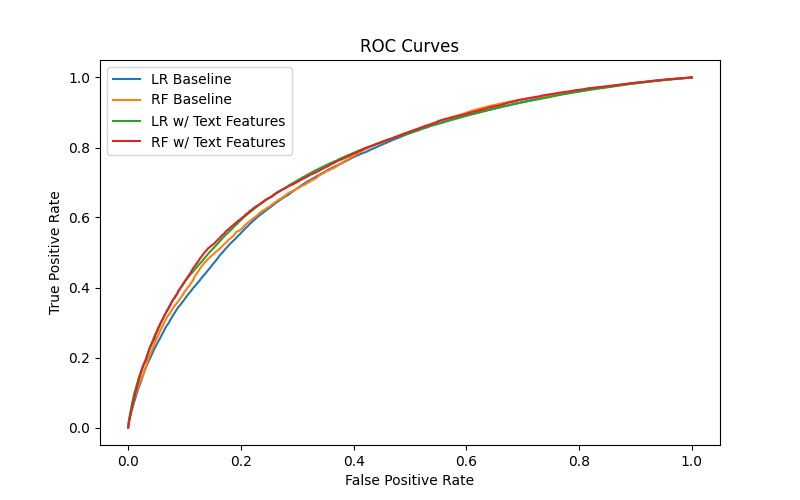

In [41]:
%matplot plt

### 7. Additional Modeling

To improve model performance, we will now use Gradient Boosted Trees to predict popularity. 

In [42]:
TF_IDF_NUM_FEATS = 20 # HashingTF(..., numFeatures=TF_IDF_NUM_FEATS)

tokenizer = Tokenizer(inputCol="title", outputCol="tokenized")
df_tokenizer = tokenizer.transform(df)
# tf frequencies
tf = HashingTF(inputCol = "tokenized", outputCol = "title_tf", numFeatures = TF_IDF_NUM_FEATS)
tf_title = tf.transform(df_tokenizer)

# idf weights
idf = IDF(inputCol = "title_tf", outputCol = "title_features_20")
idf_model = idf.fit(tf_title)
df_tf_idf = idf_model.transform(tf_title)

df_tags_arr = df_tf_idf.withColumn("artist_terms_arr", toStringArray("artist_terms"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
BOW_VOCAB_SIZE = 20
BOW_MIN_DF = 2

CV = CountVectorizer(inputCol = "artist_terms_arr", outputCol = "artist_terms_bow_20", 
                     vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)
CV_model = CV.fit(df_tags_arr)
df_final = CV_model.transform(df_tags_arr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
assembler = VectorAssembler(inputCols = ["artist_familiarity", "artist_hotttnesss", "artist_latitude",
                           "artist_longitude","duration", "end_of_fade_in", "key",
                           "key_confidence", "loudness", "mode", "mode_confidence", 
                           "start_of_fade_out","tempo","time_signature", 
                           "time_signature_confidence","year","title_features_20", 
                           "artist_terms_bow_20"], 
                            outputCol = ("features_tfidf_bowBetter"))

assembled = assembler.transform(df_final)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
scaler = StandardScaler(inputCol = "features_tfidf_bowBetter", outputCol = "scaledFeaturesAll")
df_scaled_features = scaler.fit(assembled).transform(assembled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Performance does improve!

In [46]:

from pyspark.ml.classification import GBTClassifier

train, test = df_scaled_features.randomSplit([0.8,0.2], seed=10605)


GB = GBTClassifier(featuresCol = "scaledFeaturesAll", 
                   labelCol = "label", 
                   maxDepth = 12, 
                   maxBins = 40)

GB_model = GB.fit(train)
GB_train_auc = auc.evaluate(GB_model.transform(train))
GB_test_auc = auc.evaluate(GB_model.transform(test))
print("Gradient Boosting train auc: ", GB_train_auc)
print("Gradient Boosting test auc: ", GB_test_auc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Gradient Boosting train auc:  0.9688743781701182
Gradient Boosting test auc:  0.8492214787429924